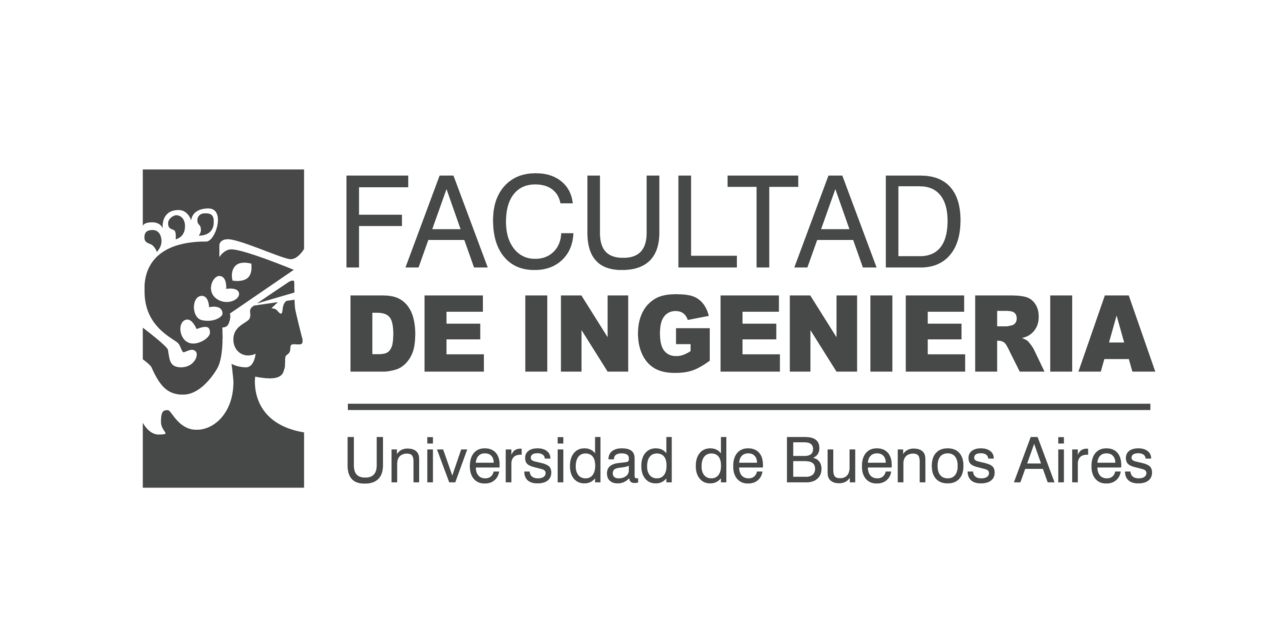

**Profesores:** <br />
Dr. Rodrigo Cardenas Szigety - rodrigo.cardenas.sz@gmail.com <br />
Dr. Nicolás Vattuone - nicolas.vattuone@gmail.com <br />

**Alumno:** <br />
Mg. Ing. Joaquin Gonzalez - joagonzalez@gmail.com <br />

**Repositorio Github**<br />
https://github.com/joagonzalez/ceia-nlp - Ver desafios/Desafio_1.ipynb<br />



### Requisitos y utilidades

In [27]:
%pip install matplotlib numpy
%pip install numpy scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [37]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import Bunch # data type de datasets en sklearn
from sklearn.metrics import f1_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [132]:
def plot_class_distribution(train_data: Bunch, test_data: Bunch, target_names: list):
    """
    Funcion que muestra distribución por clases para test y train dataset
    dada una lista con nombres de las clases target.

    Parameters:
    - train_data: Objeto que contiene el dataset de train.
    - test_data: Objeto que contiene el dataset de test y targets.
    - target_names: Lista con nombre de clases.
    """
    train_counts = [list(train_data.target).count(i) for i in range(len(target_names))]
    test_counts = [list(test_data.target).count(i) for i in range(len(target_names))]

    x = np.arange(len(target_names))
    width = 0.4

    plt.figure(figsize=(15, 6))

    # Plot para training data
    plt.bar(x - width / 2, train_counts, width, label='Train', color='blue')
    # Plot para testing data
    plt.bar(x + width / 2, test_counts, width, label='Test', color='orange')

    plt.xlabel('Clases')
    plt.ylabel('Cantidad de documentos')
    plt.title('Distribucion de clases en train y test')
    plt.xticks(x, target_names, rotation=45, ha='right')  # Rotación de etiquetas en el eje x
    plt.legend()
    plt.tight_layout()
    plt.show()

### Carga y AED

In [73]:
# cargamos los datos (ya separados de forma predeterminada en train y test)
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

In [74]:
print(newsgroups_test.keys())
print('---------')
print(newsgroups_test.data[0])
print('---------')
print(newsgroups_test.target[0])
print('---------')
print(newsgroups_train.target_names[0])

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])
---------
I am a little confused on all of the models of the 88-89 bonnevilles.
I have heard of the LE SE LSE SSE SSEI. Could someone tell me the
differences are far as features or performance. I am also curious to
know what the book value is for prefereably the 89 model. And how much
less than book value can you usually get them for. In other words how
much are they in demand this time of year. I have heard that the mid-spring
early summer is the best time to buy.
---------
7
---------
alt.atheism


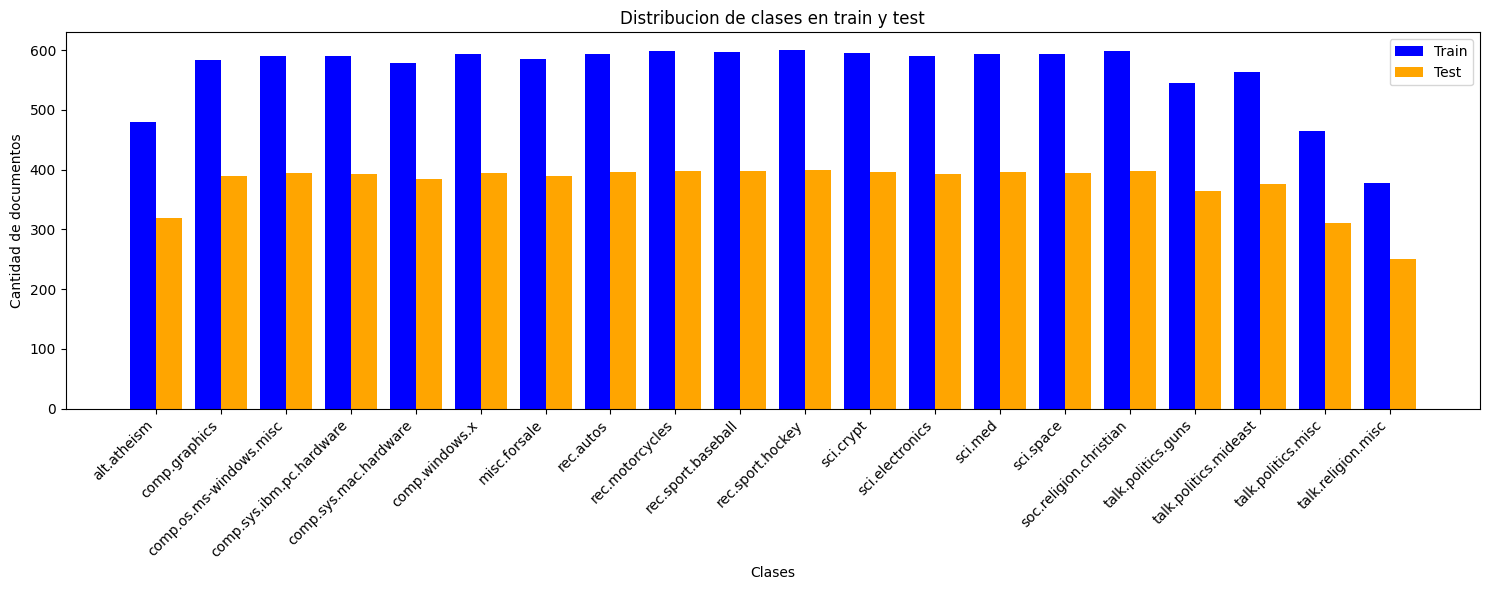

In [75]:
plot_class_distribution(newsgroups_train, newsgroups_test, newsgroups_train.target_names)

Vemos que las clases estan bien distribuidas. No deberia ser este un problema para los modelos utilizados posteriormente en el desafío.

### Desafío 1

#### Consigna

**1**. Vectorizar documentos. Tomar 5 documentos al azar y medir similaridad con el resto de los documentos.
Estudiar los 5 documentos más similares de cada uno analizar si tiene sentido
la similaridad según el contenido del texto y la etiqueta de clasificación.

**2**. Entrenar modelos de clasificación Naïve Bayes para maximizar el desempeño de clasificación
(f1-score macro) en el conjunto de datos de test. Considerar cambiar parámteros
de instanciación del vectorizador y los modelos y probar modelos de Naïve Bayes Multinomial
y ComplementNB.

**3**. Transponer la matriz documento-término. De esa manera se obtiene una matriz
término-documento que puede ser interpretada como una colección de vectorización de palabras.
Estudiar ahora similaridad entre palabras tomando 5 palabras y estudiando sus 5 más similares. **La elección de palabras no debe ser al azar para evitar la aparición de términos poco interpretables, elegirlas "manualmente"**.


#### 1. Vectorizar Documentos

In [76]:
def generate_random_indexes(dataset_length: int, count: int = 5, seed: int = 42) -> list:
    """
    Función que genera una lista de índices aleatorios para un dataset dado.

    Args:
        dataset_length (int): Tamaño del dataset.
        count (int, optional): Cantidad de índices a generar. Defaults to 5.
        seed (int, optional): Semilla para la función aleatoria. Defaults to 42.

    Returns:
        list: Lista de índices aleatorios en el rango del dataset.
    """
    random.seed(seed)
    indexes = []
    
    for i in range(count):
        index = random.randint(0, dataset_length - 1)
        indexes.append(index)
        
    print(f"Indices generados aleatoriamente: {indexes}")
    print(f"Tamaño del dataset: {dataset_length}")
        
    return indexes

indexes = generate_random_indexes(len(newsgroups_train.data))


Indices generados aleatoriamente: [10476, 1824, 409, 4506, 4012]
Tamaño del dataset: 11314


Se crea la funcion **vectorize_data()** que fitea un TF-IDF sobre train, y devuelve todo lo necesario para realizar la tarea de este punto y deja todo preparado para el punto 2 que requiere entrenamiento y validación de modelos.

In [120]:
def vectorize_data(train_data, test_data, ngram_range=(1, 1), min_df=0.0, max_df=1.0, stop_words=None, debug=True):
    """
    Utiliza TfidfVectorizer de sklearn para transformar los documentos en matrices de TF-IDF.
    Esta función permite ajustar el vectorizador a los datos de entrenamiento y luego transformar
    los datos de test. 
    Los parámetros permiten ajustar el rango de n-gramas, la frecuencia mínima y máxima

    Args:
        train_data (list): Lista de documentos del corpus de train.
        test_data (list): Lista de documentos del corpus de test.
        ngram_range (tuple): Limites para los n-gramas que serán utilizados por TfidVectorizer.
        min_df (int or float): Minima frecuencia de palabra en documentos para ser incluida en vocabulario.
        max_df (int or float): Máxima frecuencia de palabra en documentos para ser incluida en vocabulario.
        stop_words (str or list): Stop words a remover.

    Returns:
        tuple: Transformed train and test datasets, and the fitted TfidfVectorizer.
    """
    tfidfvect = TfidfVectorizer(ngram_range=ngram_range, min_df=min_df, max_df=max_df, stop_words=stop_words)
    X_train = tfidfvect.fit_transform(train_data.data)
    Y_train = train_data.target
    X_test = tfidfvect.transform(test_data.data)
    y_test = test_data.target

    idx2word = {v: k for k,v in tfidfvect.vocabulary_.items()}
    
    if debug:
        print(f'shape: {X_train.shape}')
        print(f'Cantidad de documentos en train: {X_train.shape[0]}')
        print(f'Cantidad de documentos en test: {X_test.shape[0]}')
        print(f'Cantidad de clases en train: {len(train_data.target_names)}')
        print(f'Tamaño del vocabulario (dimensionalidad de los vectores): {X_train.shape[1]}')
        print(f'Primeras 10 palabras del vocabulario aprendido: {list(idx2word.values())[:10]}')
    
    return X_train, Y_train, X_test, y_test, tfidfvect, idx2word

In [ ]:
X_train, Y_train, X_test, y_test, tfidfvect, idx2word = vectorize_data(
    newsgroups_train, 
    newsgroups_test, 
    ngram_range=(1, 1), 
    min_df=0.0, 
    max_df=1.0, 
    stop_words=None
)

shape: (11314, 101631)
Cantidad de documentos en train: 11314
Cantidad de documentos en test: 7532
Cantidad de clases en train: 20
Tamaño del vocabulario (dimensionalidad de los vectores): 101631
Primeras 10 palabras del vocabulario aprendido: ['was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on']


In [ ]:
def more_used_words(index: int, X_train, idx2word: dict) -> list:
    """
    Función que devuelve las palabras más usadas en un documento dado su índice.

    Args:
        index (int): índice que identifica al documento en el corpus.
        X_train: Corpus de documentos vectorizado.
        idx2word (dict): Diccionario que mapea índices a palabras.

    Returns:
        list: Lista de palabras más usadas en el documento.
    """
    word_counts = X_train[index].toarray().flatten()
    top_words_idx = word_counts.argsort()[::-1][:10]
    top_words = [idx2word[idx] for idx in top_words_idx]
    
    return top_words

def study_similiarities(indexes: list, X_train, Y_train, idx2word) -> None:
    """
    Función que estudia similitudes entre documentos.

    Args:
        indexes (list): Lista de índices de documentos a estudiar.
        X_train: Corpus de documentos vectorizado.
        Y_train: Clases de los documentos en el corpus.
        idx2word (dict): Diccionario que mapea índices a palabras.
    """
    for j, index in enumerate(indexes):
        print(f'Indice aleatorio {j}: {index}')
        print(f'Clase del documento: {newsgroups_train.target_names[Y_train[index]]}')
        print(f'Palabras mas usadas en el documento: {more_used_words(index, X_train, idx2word)}')    
    
        cossim = cosine_similarity(X_train[index], X_train)[0]
        mostsim = np.argsort(cossim)[::-1][1:6]

        print(f'Documentos más similares:')
        for i in mostsim:
            print(f'  Indice: {i} - Cosine similarity: {cossim[i]}')
            print(f'  Clase del documento: {newsgroups_train.target_names[Y_train[i]]}')
            print(f'Palabras mas usadas en el documento: {more_used_words(i, X_train, idx2word)}')
        print('---------------------')
        
study_similiarities(indexes, X_train, Y_train, idx2word)

Indice aleatorio 0: 10476
Clase del documento: rec.sport.hockey
Palabras mas usadas en el documento: ['series', 'coverage', 'canada', 'watch', 'games', 'swamped', 'news', 'precedence', 'televised', 'nationally']
Documentos más similares:
  Indice: 5064 - Cosine similarity: 0.22503645427838304
  Clase del documento: rec.sport.hockey
Palabras mas usadas en el documento: ['detroit', 'chicago', 'games', 'exciting', 'classic', 'mon', 'playoff', 'boston', 'fan', 'realize']
  Indice: 9623 - Cosine similarity: 0.21743229780919432
  Clase del documento: talk.politics.mideast
Palabras mas usadas en el documento: ['the', 'and', 'they', 'were', 'was', 'that', 'he', 'to', 'you', 'it']
  Indice: 10575 - Cosine similarity: 0.21644447761221192
  Clase del documento: sci.crypt
Palabras mas usadas en el documento: ['the', 'to', 'it', 'not', 'is', 'rights', 'this', 'be', 'government', 'clipper']
  Indice: 10836 - Cosine similarity: 0.21260319521108376
  Clase del documento: alt.atheism
Palabras mas usada

En lugar de analizar directamente el contenido completo de los documentos, se extrajeron las diez palabras con mayor peso TF-IDF tanto del documento base como de los documentos más similares. De esta manera resulta más eficiente para identificar patrones y explicaciones sobre la similitud observada. El número diez fue elegido de forma arbitraria, con el objetivo de mostrar el criterio utilizado.

Se observa que, en los casos con alta similitud coseno, los documentos recuperados coinciden en clase y comparten varias de las palabras más relevantes. Esto sugiere que la representación vectorial TF-IDF logra capturar algo de las relaciones semánticas entre documentos. 

Por ejemplo, para el documento aleatorio de índice **1824** (se encontro una similitud coseno alta) de clase **comp.sys.mac.hardware** las palabras más utilizadas fueron: 

- 'processor'
- '040'
- 'transidental'
- 'speed'
- 'its'
- 'is'
- 'functions'
- '486'
- 'increase'
- 'can'

Lo que coincide en clase y gran cantidad de palabras mas relevantes en documentos similares como se observa en la tabla debajo:

| Índice | Clase | Similitud coseno | Palabras más representativas |
|--------|--------|--------------------|-------------------------------|
| `9921` | `comp.sys.mac.hardware` | `0.3542` | `['speed', '20ns', 'memory', 'processor', 'clock', 'system', 'as', 'the', 'dhk', 'kitabjian']` |
| `6364` | `comp.sys.mac.hardware` | `0.3132` | `['dock', 'processor', '040', 'apple', 'notebook', 'duo', 'powerbook', 'power', 'the', 'okay']` |
| `5509` | `comp.sys.mac.hardware` | `0.3041` | `['architecture', 'speed', 'processor', 'cpu', 'performance', 'dweebs', 'ux4', 'bfd', 'ravikuma', 'riddance']` |
| `2641` | `comp.sys.mac.hardware` | `0.2504` | `['040', 'lc040', 'fpu', 'the', 'full', 'option', 'configurations', 'an', 'pop', 'configuration']` |
| `4359` | `comp.sys.mac.hardware` | `0.2417` | `['fpu', 'centris', '68rc040', 'processor', 'memo', '68lc040', 'configurations', 'apple', '650', 'non']` |

Lo contrario ocurre con documentos base que tiene similitud coseno baja con los encontrados.

#### 2. Entrenar Modelos

In [136]:
def evaluate_model(model: MultinomialNB|ComplementNB, X_test, y_test) -> float:
    """
    Función que evalúa el modelo dado y muestra el F1 score.

    Args:
        model: Modelo a evaluar.
        X_test: Datos de test.
        y_test: Clases de los datos de test.
    """
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    return f1

configurations = [
    {"ngram_range": (1, 1), "min_df": 0.01, "max_df": 0.9, "stop_words": "english"},
    {"ngram_range": (1, 2), "min_df": 0.0, "max_df": 1.0, "stop_words": "english"},
    {"ngram_range": (1, 2), "min_df": 0.1, "max_df": 0.9, "stop_words": "english"},
    {"ngram_range": (1, 2), "min_df": 0.0, "max_df": 0.85, "stop_words": "english"},
    {"ngram_range": (1, 2), "min_df": 0.01, "max_df": 0.75, "stop_words": None},
    {"ngram_range": (1, 3), "min_df": 0.01, "max_df": 0.9, "stop_words": "english"},
]

def search_and_train(configurations: dict, train: Bunch, test: Bunch) -> dict:
    """
    Función que implementa una rústica búsqueda de hiperparámetros
    para ver que vectorización TF-IDF otorga mejor información a los modelos NB.
    Se entrena un modelo MultinomialNB y ComplementNB para cada configuración.

    Args:
        configurations (dict): Diccionario con configuraciones de hiperparámetros.
        train (Bunch): _dataset_ de train.
        test (Bunch): _dataset_ de test.
    """
    results = {}
    
    for i, config in enumerate(configurations):
        print(f"Configuración {i + 1}: {config}")
        
        X_train, Y_train, X_test, y_test, tfidfvect, idx2word = vectorize_data(
            train, 
            test, 
            ngram_range=config["ngram_range"], 
            min_df=config["min_df"], 
            max_df=config["max_df"], 
            stop_words=config["stop_words"],
            debug=False
        )
        
        results[i+1] = {
            "X_train": X_train,
            "Y_train": Y_train,
            "X_test": X_test,
            "y_test": y_test,
            "tfidfvect": tfidfvect,
            "idx2word": idx2word
        }
        
        model_multinomial = MultinomialNB()
        model_multinomial.fit(X_train, Y_train)
        print(f"MultinomialNB: {evaluate_model(model_multinomial, X_test, y_test):.4f}")
        
        model_complement = ComplementNB()
        model_complement.fit(X_train, Y_train)
        print(f"ComplementNB: {evaluate_model(model_complement, X_test, y_test):.4f}")
            
        print("-" * 50)
    return results

In [137]:
results = search_and_train(configurations, newsgroups_train, newsgroups_test)

Configuración 1: {'ngram_range': (1, 1), 'min_df': 0.01, 'max_df': 0.9, 'stop_words': 'english'}
MultinomialNB: 0.5070
ComplementNB: 0.4837
--------------------------------------------------
Configuración 2: {'ngram_range': (1, 2), 'min_df': 0.0, 'max_df': 1.0, 'stop_words': 'english'}
MultinomialNB: 0.6603
ComplementNB: 0.7185
--------------------------------------------------
Configuración 3: {'ngram_range': (1, 2), 'min_df': 0.1, 'max_df': 0.9, 'stop_words': 'english'}
MultinomialNB: 0.0998
ComplementNB: 0.0880
--------------------------------------------------
Configuración 4: {'ngram_range': (1, 2), 'min_df': 0.0, 'max_df': 0.85, 'stop_words': 'english'}
MultinomialNB: 0.6603
ComplementNB: 0.7185
--------------------------------------------------
Configuración 5: {'ngram_range': (1, 2), 'min_df': 0.01, 'max_df': 0.75, 'stop_words': None}
MultinomialNB: 0.4887
ComplementNB: 0.4859
--------------------------------------------------
Configuración 6: {'ngram_range': (1, 3), 'min_df': 

Como se observa en los resultados, la mejor variante es la vectorización TF-IDF con **stop_words** n_grams de hasta 2 palabras y sin remover terminos por frecuencia. De hecho, como se observa en la configuración 3, los modelos parecen ser bastante sensibles a esto, como si hubiese mucha información que TF-IDF otorga en esas palabras.

Viendo la configuración 4, donde se remueven palabras que aparecen en el 85% o mas de los documentos (max_df=0.85), se observa que se repite el mejor valor de performance nuevamente. Esto parece indicar que las palabras repetidas (aun habiendo removido **stop_words**) no estarían aportando mucha información.

#### 3. Transponer matriz

In [166]:
# Me quedo con la configuración 4
X_train = results[4]["X_train"]
idx2word = results[4]["idx2word"]
vectorizer = results[4]["tfidfvect"]

words = ["games", "memory", "oil", "team", "computer"]

# Se transpone la matriz para que las palabras sean las filas
X_train_T = X_train.T

In [170]:
def get_similar_words(word: str, X_train_T, idx2word: dict) -> None:
    """
    Función que busca la palabra más similar a una palabra dada en el vocabulario.

    Args:
        word (str): Palabra a buscar.
        X_train: Corpus de documentos vectorizado.
        idx2word (dict): Diccionario que mapea índices a palabras.
    """
    # Se busca el índice de la palabra en el vocabulario
    word_index = vectorizer.vocabulary_.get(word)
    
    if word_index is not None:
        # Vector de esa palabra en todos los documentos
        word_vec = X_train_T[word_index]

        # Similaridad entre esa palabra y todas las demás
        similarities = cosine_similarity(word_vec, X_train_T).flatten()

        # Top 5 más similares (excluyendo a sí misma)
        most_similar_indices = similarities.argsort()[::-1][1:6]

        print(f"\n Palabra base: '{word}'")
        for i in most_similar_indices:
            similar_word = idx2word[i]
            score = similarities[i]
            print(f"   indice: {i} - {similar_word} - similitud: {score:.4f}")
    else:
        print(f"La palabra '{word}' no está en el vocabulario.")

In [171]:
for word in words:
    get_similar_words(word, X_train_T, idx2word)


 Palabra base: 'games'
   indice: 750486 - season - similitud: 0.2292
   indice: 372173 - game - similitud: 0.2227
   indice: 747787 - scoring - similitud: 0.2071
   indice: 59339 - 62 games - similitud: 0.2044
   indice: 372917 - games games - similitud: 0.1994

 Palabra base: 'memory'
   indice: 763489 - shared memory - similitud: 0.2718
   indice: 559198 - mit shm - similitud: 0.2589
   indice: 765323 - shm - similitud: 0.2528
   indice: 529853 - main memory - similitud: 0.2472
   indice: 365007 - free memory - similitud: 0.2383

 Palabra base: 'oil'
   indice: 316832 - engine oil - similitud: 0.3403
   indice: 194994 - change oil - similitud: 0.3158
   indice: 157440 - bit oil - similitud: 0.3137
   indice: 540443 - max maybe - similitud: 0.2893
   indice: 554568 - miles oil - similitud: 0.2893

 Palabra base: 'team'
   indice: 827632 - teams - similitud: 0.2824
   indice: 827604 - team win - similitud: 0.2571
   indice: 587898 - nhl - similitud: 0.2430
   indice: 827304 - team ge

**X_train = n_documentos × n_palabras**

Al transponer pasamos a tener una fila por palabra y las columnas son los documentos donde aparece.

De esta manera, podemos capturar significado semántico de las palabras según los documentos en los que aparecen aprovechando la vectorización previa de TF-IDF.

